In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import gaussian_kde, ttest_ind
from matplotlib.backends.backend_pdf import PdfPages  ###

# Paso 1: Cargar los Datos


In [8]:
# Cargar datos
data_path = 'Grupo_9.xlsx'
data = pd.read_excel(data_path, sheet_name=None)
santa_ana = data['Santa Ana']
la_floresta = data['La Floresta']

# Paso 2: Procesar los datos.

In [9]:
# Preprocesar datos dentro de un FOR
for df in [santa_ana, la_floresta]:               ###
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df['Mes'] = df['Fecha'].dt.month
    df['DiaSemana'] = df['Fecha'].dt.day_name()

print(santa_ana.head())
print(la_floresta.head())

       Fecha        Ventas  Mes  DiaSemana
0 2023-01-01   9628.330859    1     Sunday
1 2023-01-02  14290.679435    1     Monday
2 2023-01-03  12818.232667    1    Tuesday
3 2023-01-04  17404.842772    1  Wednesday
4 2023-01-05  18919.685321    1   Thursday
       Fecha        Ventas  Mes  DiaSemana
0 2023-01-01  11645.100903    1     Sunday
1 2023-01-02  13759.322193    1     Monday
2 2023-01-03  15873.983239    1    Tuesday
3 2023-01-04  17180.894218    1  Wednesday
4 2023-01-05  16358.073717    1   Thursday


# Paso 3: Definir funciones para analisis estadistico

In [10]:
# Funciones para análisis estadístico
def create_ecdf(data):
    return sm.distributions.ECDF(data)

def create_kde(data):
    return gaussian_kde(data)

def confidence_intervals(data, confidence_level=0.95): ####_______________ Corrige un error en el calculo del intervalo superior?¿¿
    alpha = 100 * (1 - confidence_level)
    lower_bound = np.percentile(data, alpha / 2)
    upper_bound = np.percentile(data, 100 - alpha / 2)
    return lower_bound, upper_bound


# Paso 3: Definir funciones para generacion de graficos y tablas

In [11]:
# Analisis Mensual 

def plot_ecdf_and_kde_to_pdf(store_data, store_name, pdf):
    """Grafica ECDF y KDE para cada mes en un documento PDF para cada tienda."""
    colors = plt.get_cmap('tab20').colors  # Usando el mapa de colores 'tab20'
    line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 10, 1, 10)), (0, (3, 1, 1, 1)),
                   (0, (5, 10)), (0, (5, 5)), (0, (5, 1)), (0, (3, 10, 1, 10, 1, 10)), (0, (3, 5, 1, 5, 1, 5))]
    markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd']
    ci_data = []  # Lista para almacenar los datos de los intervalos de confianza

    # Gráfico para ECDF
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4 en orientación horizontal
    for i, (month, group) in enumerate(store_data.groupby('Mes')['Ventas']):
        ecdf = create_ecdf(group)
        x = np.linspace(min(group), max(group), 100)
        ax.plot(x, ecdf(x), label=f'Mes {month}', color=colors[i], linestyle=line_styles[i], linewidth=2, marker=markers[i], markevery=10)

    ax.set_title(f'ECDF de {store_name}')
    ax.set_xlabel('Ventas ($)')
    ax.set_ylabel('ECDF')
    ax.legend()
    pdf.savefig(fig)  # Guarda la figura actual en el PDF
    plt.close(fig)

    # Gráfico para KDE
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4 en orientación horizontal
    for i, (month, group) in enumerate(store_data.groupby('Mes')['Ventas']):
        kde = create_kde(group)
        x = np.linspace(min(group), max(group), 100)
        ax.plot(x, kde(x), label=f'Mes {month}', color=colors[i], linestyle=line_styles[i], linewidth=2, marker=markers[i], markevery=10)
        # Almacenar intervalos de confianza para la tabla
        ci_95 = confidence_intervals(group, confidence_level=0.95)
        ci_99 = confidence_intervals(group, confidence_level=0.99)
        ci_data.append([month, f"{ci_95[0]:.2f} : {ci_95[1]:.2f}", f"{ci_99[0]:.2f} : {ci_99[1]:.2f}"])

    ax.set_title(f'KDE de {store_name}')
    ax.set_xlabel('Ventas ($)')
    ax.set_ylabel('Densidad')
    ax.legend()
    pdf.savefig(fig)  # Guarda la figura actual en el PDF
    plt.close(fig)

    # Crear y guardar la tabla en el PDF
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4
    ax.axis('tight')
    ax.axis('off')
    df = pd.DataFrame(ci_data, columns=['Mes', 'CI 95%', 'CI 99%'])
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5) 
    pdf.savefig(fig, bbox_inches='tight')  # Guardar asegurando que todo está centrado y contenido
    plt.close(fig)
    
# Analisis Diario 
    
def plot_ecdf_and_kde_to_pdf_dia(store_data, store_name, pdf):
    """Grafica ECDF y KDE por día de la semana en un documento PDF para cada tienda."""
    colors = plt.get_cmap('tab10').colors  # Usando el mapa de colores 'Paired'
    line_styles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5)), (0, (3, 10, 1, 10)), (0, (3, 1, 1, 1))]
    markers = ['o', 'v', '^', '<', '>', 's', 'p']
    ci_data = []  # Lista para almacenar los datos de los intervalos de confianza

    # Ordenar los días de la semana para una correcta visualización
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    store_data['DiaSemana'] = pd.Categorical(store_data['DiaSemana'], categories=days_order, ordered=True)
    store_data = store_data.sort_values('DiaSemana')

    # Gráfico para ECDF
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4 en orientación horizontal
    for i, (day, group) in enumerate(store_data.groupby('DiaSemana')['Ventas']):
        ecdf = create_ecdf(group)
        x = np.linspace(min(group), max(group), 100)
        ax.plot(x, ecdf(x), label=f'{day}', color=colors[i], linestyle=line_styles[i], linewidth=2, marker=markers[i], markevery=10)
        # Almacenar intervalos de confianza para la tabla
        ci_95 = confidence_intervals(group, confidence_level=0.95)
        ci_99 = confidence_intervals(group, confidence_level=0.99)
        ci_data.append([day, f"{ci_95[0]:.2f} : {ci_95[1]:.2f}", f"{ci_99[0]:.2f} : {ci_99[1]:.2f}"])
        
    ax.set_title(f'ECDF de {store_name} por Día')
    ax.set_xlabel('Ventas ($)')
    ax.set_ylabel('ECDF')
    ax.legend()
    pdf.savefig(fig)  # Guarda la figura actual en el PDF
    plt.close(fig)
    
    # Gráfico para KDE
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4 en orientación horizontal
    for i, (day, group) in enumerate(store_data.groupby('DiaSemana')['Ventas']):
        kde = create_kde(group)
        x = np.linspace(min(group), max(group), 100)
        ax.plot(x, kde(x), label=f'{day}', color=colors[i], linestyle=line_styles[i], linewidth=2, marker=markers[i], markevery=10)
    ax.set_title(f'KDE de {store_name} por Día')
    ax.set_xlabel('Ventas ($)')
    ax.set_ylabel('Densidad')
    ax.legend()
    pdf.savefig(fig)  # Guarda la figura actual en el PDF
    plt.close(fig)
    
    # Crear y guardar la tabla en el PDF
    fig, ax = plt.subplots(figsize=(11.69, 8.27))  # Tamaño A4
    ax.axis('tight')
    ax.axis('off')
    df = pd.DataFrame(ci_data, columns=['Día', 'CI 95%', 'CI 99%'])
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Ajusta la escala según necesites
    pdf.savefig(fig, bbox_inches='tight')  # Guardar asegurando que todo está centrado y contenido
    plt.close(fig)
    

# Paso 4: Generar analisis en formato PDF

In [12]:
# PDF Analisis Mensual 
with PdfPages('ANALISIS_MES.pdf') as pdf:
    # Llamada a la función para cada tienda con datos adecuados
    plot_ecdf_and_kde_to_pdf(santa_ana, 'Santa Ana', pdf)
    plot_ecdf_and_kde_to_pdf(la_floresta, 'La Floresta', pdf)
    
# PDF Analisis Diario 
with PdfPages('ANALISIS_DIA.pdf') as pdf:
    # Llamada a la función para cada tienda con datos adecuados
    plot_ecdf_and_kde_to_pdf_dia(santa_ana, 'Santa Ana', pdf)
    plot_ecdf_and_kde_to_pdf_dia(la_floresta, 'La Floresta', pdf)

C:\Users\santi_kcz1y0b\AppData\Local\Temp\ipykernel_17852\3534839723.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (day, group) in enumerate(store_data.groupby('DiaSemana')['Ventas']):
C:\Users\santi_kcz1y0b\AppData\Local\Temp\ipykernel_17852\3534839723.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (day, group) in enumerate(store_data.groupby('DiaSemana')['Ventas']):


# Paso 5: Pruebas de Hipótesis
* Realizar pruebas de hipótesis para comparar las ventas entre las dos tiendas.

Media de ventas para Santa Ana: 17753.89
Media de ventas para La Floresta: 19987.07


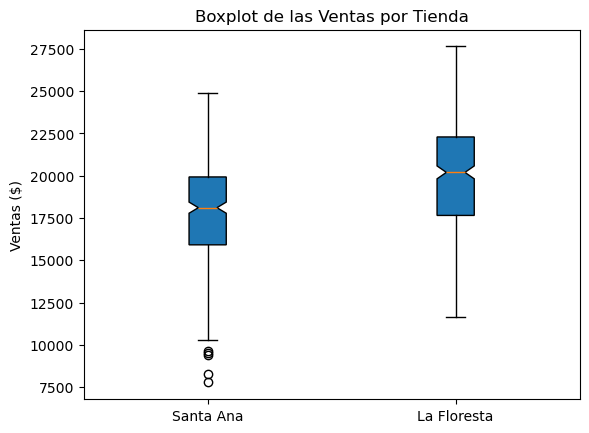


H0: Ventas de ambas tiendas son iguales:
Estadístico t: 9.857108820588982, p-valor: 1.3376077321057801e-21
Rechazamos la hipótesis nula al 95% de confianza (las ventas son diferentes)
Rechazamos la hipótesis nula al 99% de confianza (las ventas son diferentes)

H0: Ventas de 'La Floresta' son mayores o iguales que las de 'Santa Ana'.:
Estadístico t: 9.857108820588982, p-valor: 1.0


In [13]:
# Calculando las medias
media_santa_ana = santa_ana['Ventas'].mean()
media_la_floresta = la_floresta['Ventas'].mean()

print(f"Media de ventas para Santa Ana: {media_santa_ana:.2f}")
print(f"Media de ventas para La Floresta: {media_la_floresta:.2f}")

# Creando el gráfico de boxplot
data = [santa_ana['Ventas'], la_floresta['Ventas']]
fig, ax = plt.subplots()
ax.boxplot(data, notch=True, patch_artist=True, labels=['Santa Ana', 'La Floresta'])
ax.set_title('Boxplot de las Ventas por Tienda')
ax.set_ylabel('Ventas ($)')

plt.show()

# Realizar prueba t de dos muestras 
# H0: Ventas de ambas tiendas son iguales

t_stat, p_value = ttest_ind(la_floresta['Ventas'], santa_ana['Ventas'])

print(f"\nH0: Ventas de ambas tiendas son iguales:")
print(f"Estadístico t: {t_stat}, p-valor: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula al 95% de confianza (las ventas son diferentes)")
if p_value < 0.01:
    print("Rechazamos la hipótesis nula al 99% de confianza (las ventas son diferentes)")

# Realizar prueba t de dos muestras 
# H0: Ventas de 'La Floresta' son mayores o iguales que las de 'Santa Ana'

t_stat1, p_value1 = ttest_ind(la_floresta['Ventas'], santa_ana['Ventas'], alternative='less')  ##### Corrige que los supermercados estaban invertidos para el test que pedia don francisco??¿¿

print(f"\nH0: Ventas de 'La Floresta' son mayores o iguales que las de 'Santa Ana'.:")
print(f"Estadístico t: {t_stat1}, p-valor: {p_value1}")
if p_value1 < 0.05:
    print("Rechazamos la hipótesis nula al 95% de confianza ( Ventas de 'La Floresta' son mayores o igual que la de 'Santa Ana'.)")
if p_value1 < 0.01:
    print("Rechazamos la hipótesis nula al 99% de confianza ( Ventas de 'La Floresta' son mayores o igual que la de 'Santa Ana'.)")
